In [10]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/TinyML/Satellite

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TinyML/Satellite


In [2]:
%pip -q install rasterio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import colors
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 59.1 MB/s eta 0:00:00


In [3]:
import re


In [4]:
import sys

In [5]:
from tensorflow.keras.models import load_model


In [6]:
import pprint


Here the functions to pre-process the images

In [7]:
def sigmoid(x):
    '''
    sigmoid function to apply to pixel values in the image

    '''
    return 1 / (1 + np.exp(-x))

def rescale_image(image, low_percentile=30, high_percentile=70):
    # Apply log transformation
    log_image = np.log1p(image)  # Use log1p to avoid log(0)

    # Compute the percentiles
    lower_bound = np.percentile(log_image, low_percentile)
    upper_bound = np.percentile(log_image, high_percentile)

    # Apply the sigmoid function
    scaled_image = sigmoid((log_image - lower_bound) / (upper_bound - lower_bound) )

    # Clip values to [0, 1] range
    scaled_image = np.clip(scaled_image, 0, 1)
    scaled_image[image<=0] = 0

    return scaled_image


In [8]:
path_to_file= "./" # change it accordingly

In [11]:
im = Image.open(path_to_file+"Mediterranean-19-08-2019-DoT-1-Rapsberry-Pi.jpg")

In [12]:
im_R = np.array(im.getchannel("R"))/255 # /255 to convert it into the range 0-1 instead of 0-256
im_G = np.array(im.getchannel("G"))/255
im_B = np.array(im.getchannel("B"))/255
pi_img = np.dstack([im_R, im_G, im_B])

In [13]:
test_image = rescale_image(pi_img)

In [14]:
image_shape = np.shape(test_image[:,:, 0])
test_image_flatten = test_image.reshape(np.product(image_shape), 3) # flat the 2D image (with 3 channels -RGB)

Loading the TFlite model

In [15]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=path_to_file+'BLANKNet_model_quant.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.0000000e+00 1.3329149e-16]]


In [16]:
# Test the model on real data

In [17]:
interpreter.set_tensor(input_details[0]['index'], test_image_flatten[0:1].astype("float32"))
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[3.3236552e-11 1.0000000e+00]]


In [18]:
# loop to go through the image pixel by pixel

In [19]:
predicted_classes = []

In [20]:
for i in range(len(test_image_flatten)):

  interpreter.set_tensor(input_details[0]['index'], test_image_flatten[i:i+1].astype("float32"))
  interpreter.invoke()

  predictions = interpreter.get_tensor(output_details[0]['index'])

  predicted_classes.append(np.argmax(predictions, axis=1))


In [21]:
predicted_classes = np.asarray(predicted_classes)

In [22]:
cmapBLANK = colors.ListedColormap([ 'lightblue', 'black',])


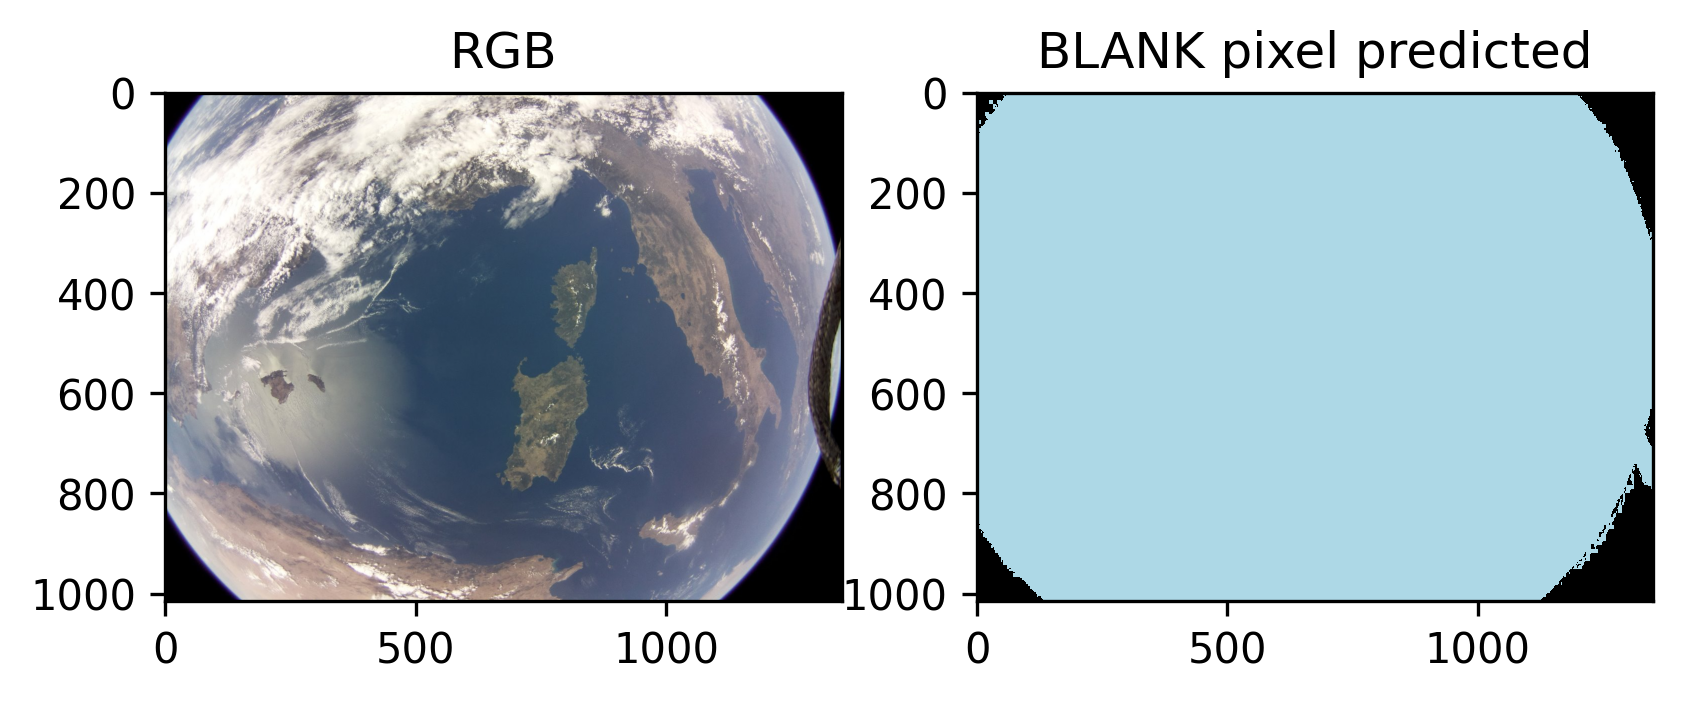

In [23]:
fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(pi_img)
ax[0].title.set_text('RGB')



ax[1].imshow(predicted_classes.reshape((image_shape[0], image_shape[1])), cmapBLANK, vmin=0, vmax=1)
ax[1].title.set_text('BLANK pixel predicted')
plt.show()